# import libraries

In [52]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np



import calendar

from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import f1_score, precision_score, recall_score
import xgboost as xgb
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier


pd.set_option('display.max_columns', None)


# Load dataset

In [2]:
df = pd.read_csv('sarah_khushboo_combined_sample.csv', low_memory=False)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 30 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Year               120000 non-null  int64  
 1   Month              120000 non-null  int64  
 2   DayofMonth         120000 non-null  int64  
 3   DayOfWeek          120000 non-null  int64  
 4   DepTime            118553 non-null  float64
 5   CRSDepTime         120000 non-null  int64  
 6   ArrTime            118365 non-null  float64
 7   CRSArrTime         120000 non-null  int64  
 8   UniqueCarrier      120000 non-null  object 
 9   FlightNum          120000 non-null  int64  
 10  TailNum            120000 non-null  object 
 11  ActualElapsedTime  118365 non-null  float64
 12  CRSElapsedTime     119942 non-null  float64
 13  AirTime            118365 non-null  float64
 14  ArrDelay           118365 non-null  float64
 15  DepDelay           118553 non-null  float64
 16  Or

In [4]:
df.isnull().sum()

Year                      0
Month                     0
DayofMonth                0
DayOfWeek                 0
DepTime                1447
CRSDepTime                0
ArrTime                1635
CRSArrTime                0
UniqueCarrier             0
FlightNum                 0
TailNum                   0
ActualElapsedTime      1635
CRSElapsedTime           58
AirTime                1635
ArrDelay               1635
DepDelay               1447
Origin                    0
Dest                      0
Distance                  0
TaxiIn                    0
TaxiOut                   0
Cancelled                 0
CancellationCode     118909
Diverted                  0
CarrierDelay          60000
WeatherDelay          60000
NASDelay              60000
SecurityDelay         60000
LateAircraftDelay     60000
Delayed                   0
dtype: int64

In [5]:
df.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,Delayed
0,2005,12,30,5,1920.0,1920,2133.0,2125,WN,2678,N684,73.0,65.0,50.0,8.0,0.0,ONT,PHX,325,13,10,0,NaN,0,0.0,0.0,0.0,0.0,0.0,Y
1,2005,4,7,4,920.0,922,1108.0,1121,AA,637,N581AA,168.0,179.0,144.0,-13.0,-2.0,ORD,ABQ,1118,11,13,0,NaN,0,0.0,0.0,0.0,0.0,0.0,N
2,2005,8,25,4,2310.0,2203,2457.0,2357,EV,4463,N837AS,107.0,114.0,-1351.0,60.0,67.0,ATL,MDT,619,1443,15,0,NaN,0,0.0,60.0,0.0,0.0,0.0,Y
3,2005,8,13,6,1106.0,1110,1251.0,1304,AA,1511,N539AA,165.0,174.0,137.0,-13.0,-4.0,RDU,DFW,1062,14,14,0,NaN,0,0.0,0.0,0.0,0.0,0.0,N
4,2005,7,15,5,610.0,615,723.0,730,AA,417,N4TKAA,133.0,135.0,105.0,-7.0,-5.0,EWR,ORD,719,5,23,0,NaN,0,0.0,0.0,0.0,0.0,0.0,N


# EDA

In [6]:
# check the Catagorical and numerical columns
cat_col = [col for col in df.columns if df[col].dtype == 'object']
num_col = [col for col in df.columns if col not in cat_col]

print(f"cat_col = {len(cat_col)}\nnum_col = {len(num_col)}\n")
print(f"Categorical col: {cat_col}\nNumerical col: {num_col}")

cat_col = 6
num_col = 24

Categorical col: ['UniqueCarrier', 'TailNum', 'Origin', 'Dest', 'CancellationCode', 'Delayed']
Numerical col: ['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'CRSDepTime', 'ArrTime', 'CRSArrTime', 'FlightNum', 'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay', 'DepDelay', 'Distance', 'TaxiIn', 'TaxiOut', 'Cancelled', 'Diverted', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']


In [7]:
#Diversion information is typically not known until after departure or during flight.
#It cannot help predict delays before the flight departs.
df['Diverted'].value_counts()

Diverted
0    119679
1       321
Name: count, dtype: int64

In [9]:
df.Delayed.value_counts()

Delayed
Y    70360
N    49640
Name: count, dtype: int64

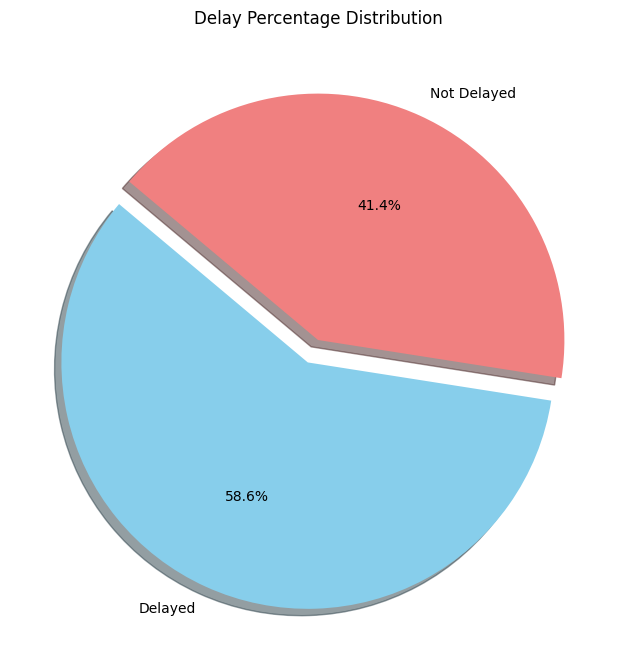

In [ ]:
sizes = df['Delayed'].value_counts()
labels = sizes.index.map({'Y': 'Delayed', 'N': 'Not Delayed'})
colors = ['skyblue', 'lightcoral']
explode = (0.1, 0)  

total = sizes.sum()
percentages = [(size / total) * 100 for size in sizes]

plt.figure(figsize=(8, 8))
plt.pie(
    sizes, 
    explode=explode, 
    labels=labels, 
    autopct='%1.1f%%', 
    colors=colors, 
    startangle=140, 
    shadow=True
)
plt.title('Delay Percentage Distribution')
plt.show()

the imbalance isn’t extreme. A ratio of approximately 59:41 can still work well for machine learning models, particularly ensemble methods like RandomForestClassifier, which are less sensitive to class imbalance.

# Data Preprocessing 

In [11]:
class DataPreProcess:

    # for num - since missing values are in time, these num features may mean like that time event did not happen (eg - DepDelay or ArrDelay
    # missing can mean that flight was not delayed)

    # for cat - assigning a specific category (e.g., "Unknown") to indicate that the cancellation reason is unknown or that 
    # the flight was not canceled.
    
    def handleMissingVals(df, col):
        df[col] = df[col].fillna(df[col].median())
        return df

    # Using Label encoding to avoid increasing dimensionality
    def encodeCatToNum(df,col):
        label_encoder = LabelEncoder()
        df[col] = label_encoder.fit_transform(df[col])
        return df

    # # drop cols that have very low correlation to target and which wont help in prediction
    def drop_cols(df,cols_to_drop):
        return df.drop(cols_to_drop, axis=1)

    def time_of_day(dep_time):
        if dep_time < 600:
            return 'Night'
        elif dep_time < 1200:
            return 'Morning'
        elif dep_time < 1800:
            return 'Afternoon'
        else:
            return 'Evening'

    def distance_categorys(distance):
        if distance < 500:
            return 'Short'
        elif distance < 1500:
            return 'Medium'
        else:
            return 'Long'

    
    def featureEng(df):
        label_encoders = {}

    
        # Time of Day feature
        df['TimeOfDay'] = df['CRSDepTime'].apply(DataPreProcess.time_of_day)
        label_encoders['TimeOfDay'] = LabelEncoder()
        df['TimeOfDay'] = label_encoders['TimeOfDay'].fit_transform(df['TimeOfDay'])
         
        # Distance category
        df['DistanceCategory'] = df['Distance'].apply(DataPreProcess.distance_categorys)
        label_encoders['DistanceCategory'] = LabelEncoder()
        df['DistanceCategory'] = label_encoders['DistanceCategory'].fit_transform(df['DistanceCategory'])
    
        # Route feature
        df['Route'] = df['Origin'].astype(str) + '_' + df['Dest'].astype(str)
        label_encoders['Route'] = LabelEncoder()
        df['Route'] = label_encoders['Route'].fit_transform(df['Route'])
    
        # Weekend indicator
        df['IsWeekend'] = df['DayOfWeek'].apply(lambda x: 1 if x in [6, 7] else 0)
    
        # Time-based features
        df['HourOfDay'] = (df['CRSDepTime'] // 100).astype(int)
        df['IsPeakHour'] = df['HourOfDay'].apply(lambda x: 1 if 6 <= x <= 9 or 16 <= x <= 19 else 0)
        
        df['DayOfMonthCategory'] = df['DayofMonth'].apply(lambda x: 'Early' if x <= 10 else 'Mid' if x <= 20 else 'Late')
        label_encoders['DayOfMonthCategory'] = LabelEncoder()
        df['DayOfMonthCategory'] = label_encoders['DayOfMonthCategory'].fit_transform(df['DayOfMonthCategory'])
        
        # Route features
        df['FlightDensity'] = df.groupby(['Origin', 'Dest'])['FlightNum'].transform('count')
        
        # Categorical encodings
        carrier_freq = df['UniqueCarrier'].value_counts().to_dict()
        df['CarrierFreq'] = df['UniqueCarrier'].map(carrier_freq)
    
        return df

        
        

In [12]:
#handleMissingVals
df = DataPreProcess.handleMissingVals(df, 'CRSElapsedTime')


#encode
categorical_cols = ['UniqueCarrier', 'Origin', 'Dest', 'Delayed']
for col in categorical_cols:
    df = DataPreProcess.encodeCatToNum(df, col)

#featureeng
df = DataPreProcess.featureEng(df)

# Drop the columns
cols_to_drop = [
    'Year',
    'Month',
    'DepTime',
    'ArrTime',
    'ActualElapsedTime',
    'ArrDelay',
    'DepDelay',
    'AirTime',
    'TaxiIn',
    'TaxiOut',
    'Diverted',
    'CarrierDelay',
    'WeatherDelay',
    'NASDelay',
    'SecurityDelay',
    'LateAircraftDelay', 
    'TailNum',               
    'FlightNum',
    'CancellationCode',
    'Cancelled' # nt useful fr flight prediction
]

df = DataPreProcess.drop_cols(df, cols_to_drop)


In [13]:
df.head()

,DayofMonth,DayOfWeek,CRSDepTime,CRSArrTime,UniqueCarrier,CRSElapsedTime,Origin,Dest,Distance,Delayed,TimeOfDay,DistanceCategory,Route,IsWeekend,HourOfDay,IsPeakHour,DayOfMonthCategory,FlightDensity,CarrierFreq
0,30,5,1920,2125,19,65.0,202,214,325,1,1,2,1762,0,19,1,1,148,17139
1,7,4,922,1121,0,179.0,203,2,1118,0,2,1,1821,0,9,1,0,21,13242
2,25,4,2203,2357,6,114.0,18,175,619,1,1,1,1401,0,22,0,1,31,2539
3,13,6,1110,1304,0,174.0,227,79,1062,0,2,1,2369,1,11,0,2,54,13242
4,15,5,615,730,0,135.0,93,205,719,0,2,1,4471,0,6,1,2,181,13242


# Feature selection

<Axes: >

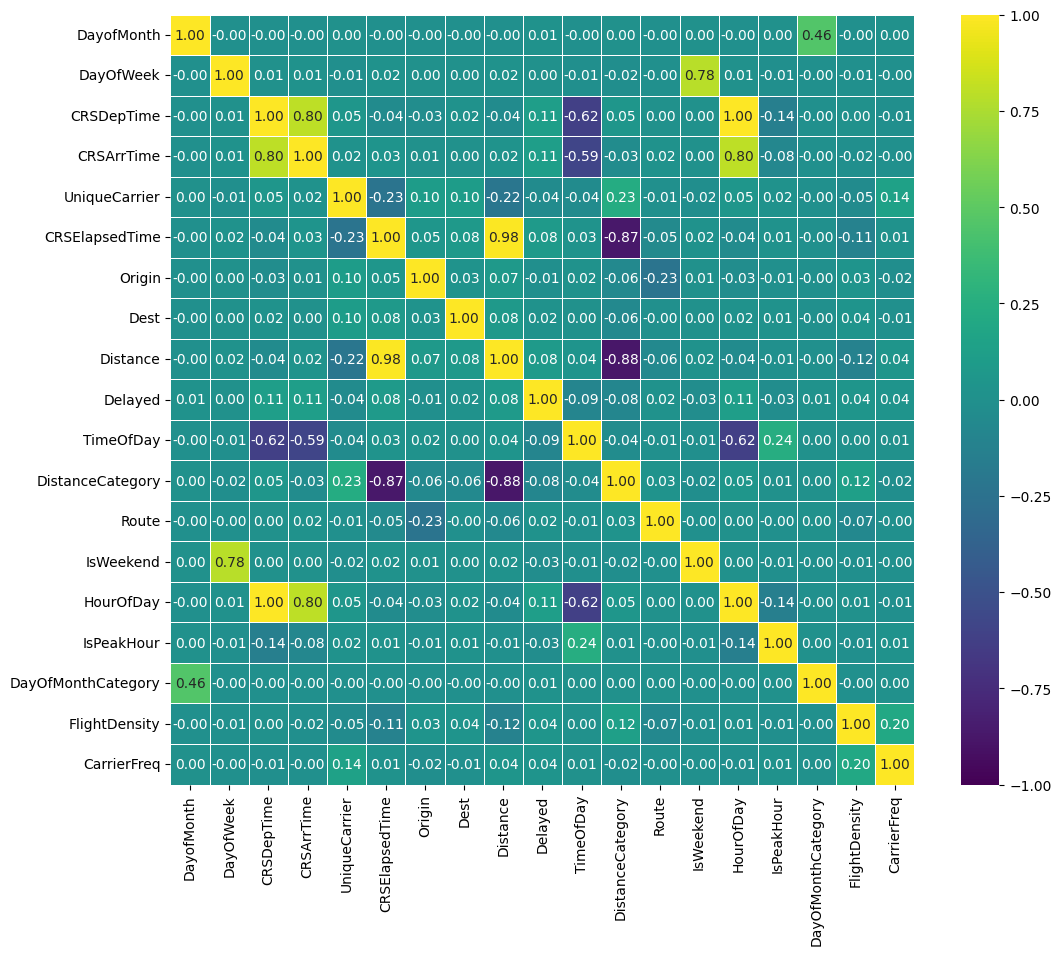

In [14]:
# Correlation Coefficient of all the Features
corr_matrix_df = df.corr()

plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix_df, vmin= -1, vmax= 1, linewidths=0.5, cmap='viridis', annot=True, fmt='.2f')   

In [15]:
# partition i/p and target
x = df.drop(columns=['Delayed'])
y = df['Delayed']

In [16]:
# Explore the best-performing features 
model_rf = RandomForestClassifier(n_estimators=250, max_depth = 1, random_state=0)

# Training model
model_rf.fit(x, y)


RandomForestClassifier(max_depth=1, n_estimators=250, random_state=0)

In [17]:
# get feature importances values for Random forest
fi_rf = pd.Series(model_rf.feature_importances_, index=x.columns).sort_values(ascending=True)
fi_rf

DayofMonth            0.000
DayOfMonthCategory    0.000
IsPeakHour            0.000
IsWeekend             0.000
Dest                  0.000
Origin                0.004
Route                 0.012
DayOfWeek             0.016
CRSElapsedTime        0.016
FlightDensity         0.016
DistanceCategory      0.040
Distance              0.048
CarrierFreq           0.052
UniqueCarrier         0.100
TimeOfDay             0.124
CRSDepTime            0.148
HourOfDay             0.156
CRSArrTime            0.268
dtype: float64

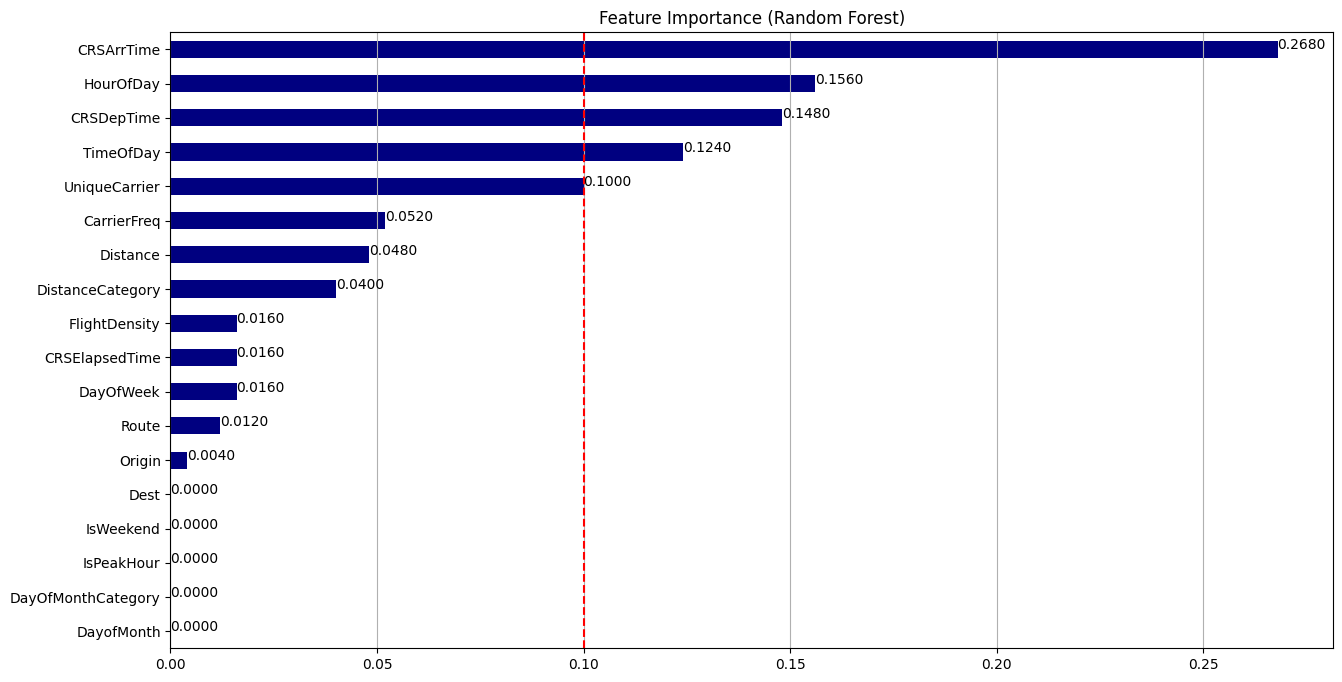

In [18]:
# Display Feature Importance 

fig, ax = plt.subplots(figsize=(15, 8))
fi_rf.plot(kind='barh', color='navy', ax=ax)
ax.set_title("Feature Importance (Random Forest)")
ax.axvline(x=0.1, linestyle='--', color='red', linewidth=1.5)
ax.grid(axis='x', linestyle='-')

for i, val in enumerate(fi_rf):
    ax.text(val, i, '{:.4f}'.format(val))

plt.show()

In [19]:
# lets choose the best features based on the importance of the feature that gives the model the best accuracy score.

df_fi = df[fi_rf[fi_rf >= 0].index]   

# Overview df_fi dataframe
df_fi.head()

,DayofMonth,DayOfMonthCategory,IsPeakHour,IsWeekend,Dest,Origin,Route,DayOfWeek,CRSElapsedTime,FlightDensity,DistanceCategory,Distance,CarrierFreq,UniqueCarrier,TimeOfDay,CRSDepTime,HourOfDay,CRSArrTime
0,30,1,1,0,214,202,1762,5,65.0,148,2,325,17139,19,1,1920,19,2125
1,7,0,1,0,2,203,1821,4,179.0,21,1,1118,13242,0,2,922,9,1121
2,25,1,0,0,175,18,1401,4,114.0,31,1,619,2539,6,1,2203,22,2357
3,13,2,0,1,79,227,2369,6,174.0,54,1,1062,13242,0,2,1110,11,1304
4,15,2,1,0,205,93,4471,5,135.0,181,1,719,13242,0,2,615,6,730


In [61]:
# Dividing Dataset into Features & Label
x = df[fi_rf[fi_rf >= 0].index]
y = df['Delayed']
x

,DayofMonth,DayOfMonthCategory,IsPeakHour,IsWeekend,Dest,Origin,Route,DayOfWeek,CRSElapsedTime,FlightDensity,DistanceCategory,Distance,CarrierFreq,UniqueCarrier,TimeOfDay,CRSDepTime,HourOfDay,CRSArrTime
0,30,1,1,0,214,202,1762,5,65.0,148,2,325,17139,19,1,1920,19,2125
1,7,0,1,0,2,203,1821,4,179.0,21,1,1118,13242,0,2,922,9,1121
2,25,1,0,0,175,18,1401,4,114.0,31,1,619,2539,6,1,2203,22,2357
3,13,2,0,1,79,227,2369,6,174.0,54,1,1062,13242,0,2,1110,11,1304
4,15,2,1,0,205,93,4471,5,135.0,181,1,719,13242,0,2,615,6,730
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119995,20,2,1,0,71,264,3057,5,102.0,18,1,583,15309,5,2,620,6,802
119996,17,2,1,0,77,74,4011,2,72.0,10,2,391,11623,18,1,1910,19,2022
119997,30,1,0,0,213,259,2996,2,128.0,17,1,813,3240,15,1,2100,21,8
119998,22,1,0,0,270,29,3269,1,80.0,14,2,460,17139,19,2,1140,11,1400


In [21]:
df.isnull().sum()

DayofMonth            0
DayOfWeek             0
CRSDepTime            0
CRSArrTime            0
UniqueCarrier         0
CRSElapsedTime        0
Origin                0
Dest                  0
Distance              0
Delayed               0
TimeOfDay             0
DistanceCategory      0
Route                 0
IsWeekend             0
HourOfDay             0
IsPeakHour            0
DayOfMonthCategory    0
FlightDensity         0
CarrierFreq           0
dtype: int64

# Model Development

In [62]:
# Divide data and class labels into training set and test set with 80:20 ratio
X_train_full, X_test, y_train_full, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

# Further splitting the train set to 20% validation
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.20, random_state=42)

In [63]:
print(f"x_train: {X_train.shape}\ny_train: {y_train.shape}\n\nx_test: {X_test.shape}\ny_test: {y_test.shape} \n\nx_val: {X_val.shape}\ny_val: {y_val.shape}")

x_train: (72000, 18)
y_train: (72000,)

x_test: (24000, 18)
y_test: (24000,) 

x_val: (24000, 18)
y_val: (24000,)


In [24]:
model = RandomForestClassifier()

# Training the model
model.fit(X_train, y_train)

RandomForestClassifier()

In [25]:
# Evaluate the initial model's performance on the test set
model.score(X_test, y_test)

0.6075416666666666

In [26]:
# Evaluate the initial performance on the validation set
y_pred_val = model.predict(X_val)
print("Initial Validation Performance:")
print(classification_report(y_val, y_pred_val))

Initial Validation Performance:
              precision    recall  f1-score   support

           0       0.54      0.43      0.48      9925
           1       0.65      0.74      0.69     14075

    accuracy                           0.61     24000
   macro avg       0.59      0.58      0.58     24000
weighted avg       0.60      0.61      0.60     24000



### Find the parameter for Random Forest

In [27]:
# Define the parameter grid 
# param_grid = {
#     'n_estimators': [100, 150],  
#     'max_features': [0.3, 0.5], 
#     'max_depth': [None, 10]      
# }

param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_features': [0.3, 0.5, 0.7],
    'max_depth': [None, 10, 20]
}

# Instantiate the RandomForestClassifier
ranfor = RandomForestClassifier(random_state=0)

# Instantiate GridSearchCV with fewer folds (e.g., cv=5) and parallelization
grid_search = GridSearchCV(estimator = RandomForestClassifier(),
                           param_grid = param_grid, verbose = 10, refit = True)


In [29]:
# Perform GridSearchCV for hyperparameter tuning
grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 1/5; 1/36] START max_depth=None, max_features=0.3, n_estimators=50..........
[CV 1/5; 1/36] END max_depth=None, max_features=0.3, n_estimators=50;, score=0.606 total time=   6.4s
[CV 2/5; 1/36] START max_depth=None, max_features=0.3, n_estimators=50..........
[CV 2/5; 1/36] END max_depth=None, max_features=0.3, n_estimators=50;, score=0.601 total time=   6.6s
[CV 3/5; 1/36] START max_depth=None, max_features=0.3, n_estimators=50..........
[CV 3/5; 1/36] END max_depth=None, max_features=0.3, n_estimators=50;, score=0.594 total time=   6.4s
[CV 4/5; 1/36] START max_depth=None, max_features=0.3, n_estimators=50..........
[CV 4/5; 1/36] END max_depth=None, max_features=0.3, n_estimators=50;, score=0.603 total time=   6.4s
[CV 5/5; 1/36] START max_depth=None, max_features=0.3, n_estimators=50..........
[CV 5/5; 1/36] END max_depth=None, max_features=0.3, n_estimators=50;, score=0.597 total time=   6.4s
[CV 1/5; 2/36] START ma

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 10, 20],
                         'max_features': [0.3, 0.5, 0.7],
                         'n_estimators': [50, 100, 150, 200]},
             verbose=10)

In [30]:
# Get the best estimator (model) from GridSearchCV
best_model = grid_search.best_estimator_
best_model

RandomForestClassifier(max_depth=10, max_features=0.3, n_estimators=150)

In [31]:
# save model
import joblib

# Save the best model to a file
joblib.dump(best_model, 'best_random_forest_model.pkl')

# Verify if the model is saved correctly by loading it
loaded_model = joblib.load('best_random_forest_model.pkl')
print(loaded_model)

RandomForestClassifier(max_depth=10, max_features=0.3, n_estimators=150)


In [32]:
# Evaluate the best model
print("\nBest Model Parameters:", grid_search.best_params_)


Best Model Parameters: {'max_depth': 10, 'max_features': 0.3, 'n_estimators': 150}


In [33]:
# Perform cross-validation using Stratified K-Fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation and compute scores
cross_val_scores = cross_val_score(best_model, X_train, y_train, cv=cv, scoring='accuracy')

# Print cross-validation scores
print("Cross-validation scores:", cross_val_scores)

# Calculate the mean and standard deviation of the cross-validation scores
mean_accuracy = np.mean(cross_val_scores)
std_accuracy = np.std(cross_val_scores)

print("Mean accuracy:", mean_accuracy)
print("Standard deviation of accuracy:", std_accuracy)


Cross-validation scores: [0.62611111 0.62381944 0.61673611 0.62229167 0.62      ]
Mean accuracy: 0.6217916666666667
Standard deviation of accuracy: 0.0032183285862212333


In [34]:
# CONFUSION MATRIX IN TERMS OF %

def plot_confusion_matrix_and_metrics_advanced(y_true, y_pred):
    
    group_names = ['True Negative', 'False Positive','False Negative','True Positive']
    categories = ['0 : Not Delayed', '1 : Delayed']
    
    # Generate confusion matrix
    conf = confusion_matrix(y_true, y_pred)
    
    # Calculate group counts and percentages for confusion matrix
    group_counts = ["{0:0.0f}".format(value) for value in conf.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in conf.flatten()/np.sum(conf)]
    
    # Create labels for confusion matrix cells
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.array(labels).reshape(len(categories), len(categories))
    
    # Plot confusion matrix using seaborn heatmap
    sns.heatmap(conf, annot=labels, fmt='', cmap='Blues',
                xticklabels=categories, yticklabels=categories)
    
    # Calculate performance metrics
    f1 = f1_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    
    # Add metrics information to the plot
    plt.xlabel(f"Predicted Label\n\nF1 score: {f1:.3f}\nRecall: {recall:.4f}\nPrecision: {precision:.4f}")
    plt.ylabel('Actual Label')
    plt.title('Confusion Matrix')
    plt.savefig('plot_name1.png')  # Save the plot as an image
    plt.show()

In [35]:
y_pred_valid = best_model.predict(X_val)

val_accuracy = best_model.score(X_val, y_val)
print("Validation Accuracy:", val_accuracy)

# Calculate accuracy
accuracy_val = accuracy_score(y_val, y_pred_valid)
print("Accuracy score:", accuracy_val)
 
confidence_levels = np.sum(y_val == y_pred_valid) / len(y_val)
print("Confidence Levels:", confidence_levels)

Validation Accuracy: 0.6255833333333334
Accuracy score: 0.6255833333333334
Confidence Levels: 0.6255833333333334


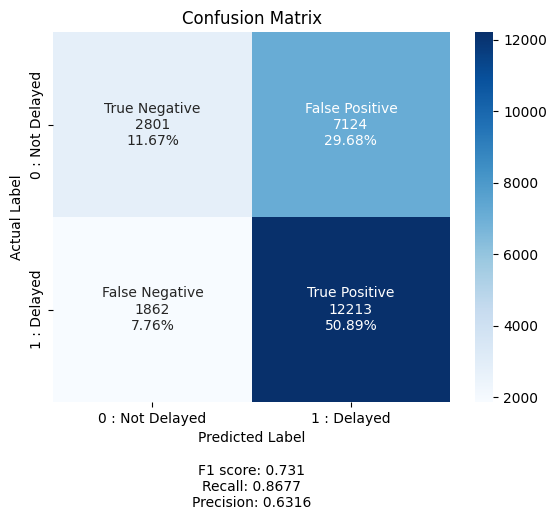

In [36]:
plot_confusion_matrix_and_metrics_advanced(y_val, y_pred_valid)

# using Gradient boosting modelS (Model 2)

In [65]:
# Train XGBoost
xgb_model = xgb.XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

# Train LightGBM
lgbm_model = LGBMClassifier(
    n_estimators=200,
    max_depth=7,
    num_leaves=63,
    min_data_in_leaf=50,
    min_gain_to_split=0.1,
    max_bin=255,
    learning_rate=0.05,
    random_state=42
)
lgbm_model.fit(X_train, y_train)

# Train CatBoost
catboost_model = CatBoostClassifier(iterations=100, depth=5, learning_rate=0.1, random_state=42, verbose=0)
catboost_model.fit(X_train, y_train)


[LightGBM] [Warning] min_gain_to_split is set=0.1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_gain_to_split is set=0.1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Number of positive: 42287, number of negative: 29713
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000701 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1935
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.587319 -> initscore=0.352895
[Ligh

In [66]:
from sklearn.ensemble import VotingClassifier

# Voting Ensemble
voting_model = VotingClassifier(estimators=[
    ('xgb', xgb_model),
    ('lgbm', lgbm_model),
    ('catboost', catboost_model)
], voting='soft') 

# Train the voting ensemble
voting_model.fit(X_train, y_train)


[LightGBM] [Warning] min_gain_to_split is set=0.1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_gain_to_split is set=0.1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Number of positive: 42287, number of negative: 29713
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000734 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1935
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.587319 -> initscore=0.352895
[Ligh

VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_ra...
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...)),
                             ('lgbm',
                              LGBMClassifier(learning_rate=0.05, max_bin=255,
                                             max_depth=7, min_data_in_leaf=50,
                                             min_gain_to_split=0.1,
                                             n_estimators=200, num_leaves=63,
                                             random_state=42)),
                             ('catboost',
                              <catboost.core.CatBoostClassifier object at 0x168751750>)],
                 voting='soft')

In [69]:
# Individual model predictions
xgb_pred = xgb_model.predict(X_val)
lgbm_pred = lgbm_model.predict(X_val)
catboost_pred = catboost_model.predict(X_val)

# Voting ensemble predictions
voting_pred = voting_model.predict(X_val)

# Metrics function
from sklearn.metrics import classification_report

print("XGBoost Metrics:")
print(classification_report(y_val, xgb_pred))

print("LightGBM Metrics:")
print(classification_report(y_val, lgbm_pred))

print("CatBoost Metrics:")
print(classification_report(y_val, catboost_pred))

print("Voting Ensemble Metrics:")
print(classification_report(y_val, voting_pred))


[LightGBM] [Warning] min_gain_to_split is set=0.1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_gain_to_split is set=0.1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
XGBoost Metrics:
              precision    recall  f1-score   support

           0       0.60      0.34      0.43      9925
           1       0.64      0.84      0.73     14075

    accuracy                           0.63     24000
   macro avg       0.62      0.59      0.58     24000
weighted avg       0.62      0.63      0.60     24000

LightGBM Metrics:
              precision    recall  f1-score   support

           0       0.59      0.36      0.45      9925
           1       0.65      0.82    

In [71]:
from sklearn.metrics import accuracy_score, precision_score

models = {
    'XGBoost': xgb_model,
    'LightGBM': lgbm_model,
    'CatBoost': catboost_model,
    'Voting Ensemble': voting_model
}

for name, model in models.items():
    # Predict on validation set
    y_val_pred = model.predict(X_val)
    
    # Compute metrics
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_precision = precision_score(y_val, y_val_pred, average='weighted')  # Use 'weighted' for imbalanced data
    
    # Display results
    print(f"{name} Validation Accuracy: {val_accuracy:.4f}")
    print(f"{name} Validation Precision: {val_precision:.4f}")
    print(f"{name} Confidence Levels (Accuracy): {val_accuracy:.4f}\n")


XGBoost Validation Accuracy: 0.6312
XGBoost Validation Precision: 0.6228
XGBoost Confidence Levels (Accuracy): 0.6312

[LightGBM] [Warning] min_gain_to_split is set=0.1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
LightGBM Validation Accuracy: 0.6314
LightGBM Validation Precision: 0.6223
LightGBM Confidence Levels (Accuracy): 0.6314

CatBoost Validation Accuracy: 0.6252
CatBoost Validation Precision: 0.6181
CatBoost Confidence Levels (Accuracy): 0.6252

[LightGBM] [Warning] min_gain_to_split is set=0.1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
Voting Ensemble Validation Accuracy: 0.6309
Voting Ensemble Validation Precision: 0.6230
Voting Ensemble Confidence Levels (Accuracy): 0.6309



# predicting on given 

In [90]:
given_df = pd.read_excel("results_test_file.xlsx")

In [91]:
given_df.head(70)

,Student,Unnamed: 1,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,Delayed
0,Adejumo,Azeez,NaN,NaN,2,1,NaN,1455,NaN,1650,WN,227,N698SW,NaN,55,NaN,NaN,NaN,ABQ,AMA,277,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Adejumo,Azeez,NaN,NaN,2,1,NaN,1900,NaN,2153,UA,1746,N9022U,NaN,113,NaN,NaN,NaN,ORD,PHL,678,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Adejumo,Azeez,NaN,NaN,4,1,NaN,700,NaN,755,AS,60,NaN,NaN,55,NaN,NaN,NaN,JNU,KTN,0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Adejumo,Azeez,NaN,NaN,9,1,NaN,1455,NaN,1650,WN,227,N664WN,NaN,55,NaN,NaN,NaN,ABQ,AMA,277,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Adejumo,Azeez,NaN,NaN,9,1,NaN,645,NaN,937,UA,482,N7288U,NaN,112,NaN,NaN,NaN,ORD,PHL,678,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,Dudipala,Srinivas,NaN,NaN,2,6,NaN,700,NaN,755,AS,60,NaN,NaN,55,NaN,NaN,NaN,JNU,KTN,0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66,Dudipala,Srinivas,NaN,NaN,7,6,NaN,1455,NaN,1650,WN,2742,N446,NaN,55,NaN,NaN,NaN,ABQ,AMA,277,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67,Dudipala,Srinivas,NaN,NaN,7,6,NaN,645,NaN,937,UA,482,N7449U,NaN,112,NaN,NaN,NaN,ORD,PHL,678,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68,Dudipala,Srinivas,NaN,NaN,9,6,NaN,700,NaN,755,AS,60,NaN,NaN,55,NaN,NaN,NaN,JNU,KTN,0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [92]:
given_df.isnull().sum()

Student                0
Unnamed: 1             0
Year                 210
Month                210
DayofMonth             0
DayOfWeek              0
DepTime              210
CRSDepTime             0
ArrTime              210
CRSArrTime             0
UniqueCarrier          0
FlightNum              0
TailNum               71
ActualElapsedTime    210
CRSElapsedTime         0
AirTime              210
ArrDelay             210
DepDelay             210
Origin                 0
Dest                   0
Distance               0
TaxiIn               210
TaxiOut              210
Cancelled              0
CancellationCode     210
Diverted             210
CarrierDelay         210
WeatherDelay         210
NASDelay             210
SecurityDelay        210
LateAircraftDelay    210
Delayed              209
dtype: int64

In [93]:
predict_df = given_df.copy()

In [94]:
predict_df.dtypes

Student               object
Unnamed: 1            object
Year                 float64
Month                float64
DayofMonth             int64
DayOfWeek              int64
DepTime              float64
CRSDepTime             int64
ArrTime              float64
CRSArrTime             int64
UniqueCarrier         object
FlightNum              int64
TailNum               object
ActualElapsedTime    float64
CRSElapsedTime         int64
AirTime              float64
ArrDelay             float64
DepDelay             float64
Origin                object
Dest                  object
Distance               int64
TaxiIn               float64
TaxiOut              float64
Cancelled              int64
CancellationCode     float64
Diverted             float64
CarrierDelay         float64
WeatherDelay         float64
NASDelay             float64
SecurityDelay        float64
LateAircraftDelay    float64
Delayed               object
dtype: object

In [ ]:
#handleMissingVals
predict_df = DataPreProcess.handleMissingVals(predict_df, 'CRSElapsedTime')


#encode
categorical_cols = ['UniqueCarrier', 'Origin', 'Dest', 'Delayed']
for col in categorical_cols:
    df = DataPreProcess.encodeCatToNum(predict_df, col)

#featureeng
predict_df = DataPreProcess.featureEng(predict_df)

# Drop the columns
cols_to_drop = [
    'Year',
    'Month',
    'DepTime',
    'ArrTime',
    'ActualElapsedTime',
    'ArrDelay',
    'DepDelay',
    'AirTime',
    'TaxiIn',
    'TaxiOut',
    'Diverted',
    'CarrierDelay',
    'WeatherDelay',
    'NASDelay',
    'SecurityDelay',
    'LateAircraftDelay', 
    'TailNum',               
    'FlightNum',
    'CancellationCode',
    'Cancelled' # not useful fr flight prediction
]

predict_df = DataPreProcess.drop_cols(predict_df, cols_to_drop)


In [96]:
predict_df = predict_df[fi_rf[fi_rf >= 0].index]

In [97]:
# # Filter rows where FlightNum equals 187
# flights_with_187_and_us = df[(df['FlightNum'] == 60) & (df['UniqueCarrier'] == 'AS')]

# flights_with_187_and_us

In [98]:
predict_df

,DayofMonth,DayOfMonthCategory,IsPeakHour,IsWeekend,Dest,Origin,Route,DayOfWeek,CRSElapsedTime,FlightDensity,DistanceCategory,Distance,CarrierFreq,UniqueCarrier,TimeOfDay,CRSDepTime,HourOfDay,CRSArrTime
0,2,0,0,0,0,1,6,1,55,10,2,277,10,3,0,1455,14,1650
1,2,0,1,0,6,8,13,1,113,31,1,678,31,1,1,1900,19,2153
2,4,0,1,0,4,6,11,1,55,69,2,0,71,0,2,700,7,755
3,9,0,0,0,0,1,6,1,55,10,2,277,10,3,0,1455,14,1650
4,9,0,1,0,6,8,13,1,112,31,1,678,31,1,2,645,6,937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,2,0,1,0,4,6,11,3,50,69,2,0,71,0,2,710,7,800
206,8,0,1,0,5,11,2,3,198,4,1,1440,98,2,2,830,8,1248
207,8,0,0,0,6,11,3,3,257,10,0,2075,98,2,1,2315,23,532
208,9,0,1,0,4,6,11,3,50,69,2,0,71,0,2,710,7,800


In [99]:
#using random forest
# predictions = best_model.predict(predict_df)

In [100]:
# using lightgbm
predictions = lgbm_model.predict(predict_df)

[LightGBM] [Warning] min_gain_to_split is set=0.1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50


In [101]:
predictions

array([1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0])

In [102]:
# given_df["Delayed"] = predictions
given_df["Delayed"] = pd.Series(predictions).map({1: "Y", 0: "N"})

In [103]:
# this is the actual new dataset
given_df.loc[70:79]

,Student,Unnamed: 1,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,Delayed
70,George,Sarah Annie,NaN,NaN,14,6,NaN,815,NaN,1000,US,187,0,NaN,105,NaN,NaN,NaN,ABE,CLT,481,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
71,George,Sarah Annie,NaN,NaN,16,6,NaN,700,NaN,755,AS,60,NaN,NaN,55,NaN,NaN,NaN,JNU,KTN,0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
72,George,Sarah Annie,NaN,NaN,21,6,NaN,815,NaN,1000,US,187,N702UW,NaN,105,NaN,NaN,NaN,ABE,CLT,481,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
73,George,Sarah Annie,NaN,NaN,21,6,NaN,645,NaN,937,UA,482,N7276U,NaN,112,NaN,NaN,NaN,ORD,PHL,678,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
74,George,Sarah Annie,NaN,NaN,23,6,NaN,700,NaN,755,AS,60,NaN,NaN,55,NaN,NaN,NaN,JNU,KTN,0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
75,George,Sarah Annie,NaN,NaN,28,6,NaN,815,NaN,1000,US,187,N717UW,NaN,105,NaN,NaN,NaN,ABE,CLT,481,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
76,George,Sarah Annie,NaN,NaN,28,6,NaN,645,NaN,937,UA,482,N7270U,NaN,112,NaN,NaN,NaN,ORD,PHL,678,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
77,George,Sarah Annie,NaN,NaN,30,6,NaN,830,NaN,1111,AS,60,NaN,NaN,101,NaN,NaN,NaN,KTN,SEA,0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
78,George,Sarah Annie,NaN,NaN,1,7,NaN,1455,NaN,1650,WN,227,N671SW,NaN,55,NaN,NaN,NaN,ABQ,AMA,277,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y
79,George,Sarah Annie,NaN,NaN,1,7,NaN,1900,NaN,2153,UA,1746,N9053U,NaN,113,NaN,NaN,NaN,ORD,PHL,678,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y


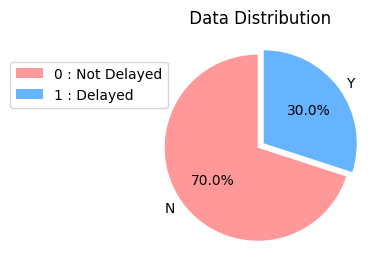

In [104]:
colors = ['#ff9999', '#66b3ff']

counts = given_df.loc[72:81, "Delayed"].value_counts()

# Plot pie chart 
plt.subplot(1, 2, 2)
plt.pie(counts, labels=counts.index, autopct='%1.1f%%',
        startangle=90, explode=[0, 0.08], colors=colors)
plt.title(' Data Distribution')

plt.legend(['0 : Not Delayed', '1 : Delayed'], loc=9, bbox_to_anchor=(-0.225, 0.9))

plt.tight_layout()
plt.show()

In [105]:
given_df.loc[70:79].to_csv("final_test_file_lightgbm_predictions.csv", index=False)